# Mandarin Tone Recognition with a Recurrent Neural Network

This notebook develops a recurent neural network for the classification of Mandarin tones from an audio sample. The model architechture is shown below:

<img src="RNN classification illustration.png">

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import random

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

%matplotlib inline

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Database preparation

Audio files are saved on google drive as .rar file. The first step is to copy these to the colab VM drive and extract the content

In [0]:
!cp -r "/content/drive/My Drive/wav.rar" ./wav.rar
!unrar x wav.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from wav.rar

Creating    wav                                                       OK
Extracting  wav/一.wav                                                      0%  OK 
Extracting  wav/一共.wav                                                     0%  OK 
Extracting  wav/一切.wav                                                     0%  OK 
Extracting  wav/一定.wav                                                     0%  OK 
Extracting  wav/一度.wav                                                     0%  OK 
Extracting  wav/一旦.wav                                                     0%  OK 
Extracting  wav/一會兒.wav                                                    0%  OK 
Extracting  wav/一樣.wav                                                     0%  OK 
Extracting  wav/一直.wav                                                     0%  OK 
Extra

The spectrogram of an audio signal can be obtained using the singal library in scipy. The resulting 2d array consists of Fourier transforms of small audio chunks. The changes in the peaks of these Fourier transforms across the time of the audio signal illustrate changes in tone.

In [0]:
from scipy import signal
from scipy.io import wavfile

In [0]:
wav_dir = '/content/wav/'

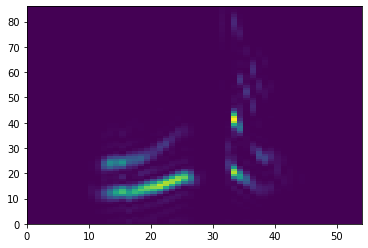

In [0]:
fs, data = wavfile.read(wav_dir + '一共.wav')

f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024, nfft=1024*4)
Sxx = Sxx[:86]
plt.pcolormesh(Sxx)
plt.show()

Load the vocabulary list with corresponding pinyin and tones. These were built when audio files were downloaded from Wiktionary.

In [0]:
import json

In [0]:
with open('/content/drive/My Drive/tones.txt', 'r') as file:
  tones = json.load(file)

In [0]:
vocab = tones.keys()

In [0]:
def get_spectrogram(hanzi):
  """
  Returns the spectrogram for the audio sample of a Chinese 
  word (hanzi) saved in the /content/wav/ directory
  """
  fs, data = wavfile.read(wav_dir + hanzi + '.wav')

  if len(data.shape) > 1:
    data = data[:, 0]

  f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024, nfft=1024*4)
  Sxx = Sxx[:86]
  return Sxx

Leading and trailing silences in the audio samples will increase the size of the input without adding useful information for tone discrimination. The following is a function that removes these silences.

In [0]:
def trim_silences(Sxx):
  """
  Removes leading and trailing silence from a spectrogram
  Silence is defined as a maximum amplitude less than 1% of 
  the overall spectrogram maximum amplitude
  Returns the trimmed spectrogram
  """
  non_silent = list(np.max(Sxx, axis=0) > np.max(Sxx) * 0.01)
  start_id = non_silent.index(True)
  stop_id = len(non_silent) - 1 - non_silent[::-1].index(True)

  return Sxx[:, start_id:stop_id]

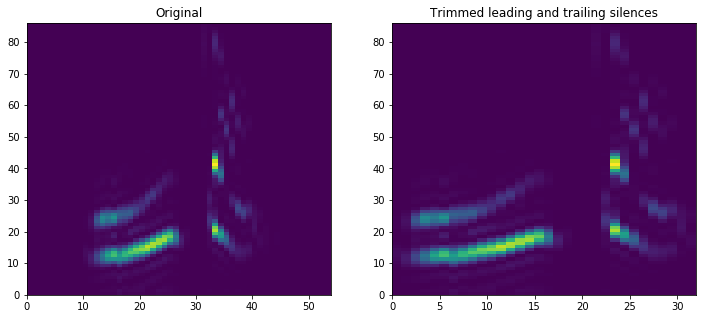

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].pcolormesh(Sxx)
ax[0].set_title("Original")
ax[1].pcolormesh(trim_silences(Sxx))
ax[1].set_title("Trimmed leading and trailing silences")
plt.show()

The majority of Chinese words include two sylables, each with an associated tone. To predict the tone from the audio sample, the sample must first be split into individual sylables. The following function achieves this by searching the central two quarters of the time domain for the time with the lowest maximum amplitude.

In [0]:
def split_spectrogram(Sxx):
    """
    Divides the spectrogram of a two sylable word into its component spectrograms
    Returns a list [Spectrogram for sylable 1, Spectrogram for sylable 2]
    """
    q1 = Sxx.shape[1]//4
    q3 = 3*q1
    center = np.argmin(Sxx[:, q1:q3].max(axis=0))
    return trim_silences(Sxx[:, :q1+center]), trim_silences(Sxx[:, q1+center:])

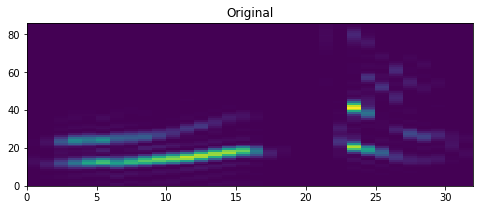

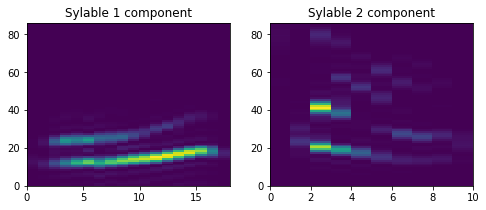

In [0]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.pcolormesh(trim_silences(Sxx))
ax.set_title("Original")
plt.show()

Sxx1, Sxx2 = split_spectrogram(trim_silences(Sxx))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].pcolormesh(Sxx1)
ax[0].set_title("Sylable 1 component")
ax[1].pcolormesh(Sxx2)
ax[1].set_title("Sylable 2 component")
plt.show()

We now apply the previous functions to each Chinese word with available audio sample and add the results to a pandas dataframe

In [0]:
tones_list = []
for hanzi in vocab:
    if os.path.exists(wav_dir + hanzi + '.wav'):
        if len(hanzi) == 1:
            tones[hanzi]['hanzi'] = hanzi
            tones[hanzi]['Sxx'] = trim_silences(get_spectrogram(hanzi))
            tones[hanzi]['tones'] = tones[hanzi]['tones'][0]
            tones_list.append(tones[hanzi])
        elif len(hanzi) == 2:
            Sxx = trim_silences(get_spectrogram(hanzi))
            Sxx1, Sxx2 = split_spectrogram(Sxx)
            tones_list.append({'hanzi': hanzi+'[0]', 
                            'pinyin': tones[hanzi]['pinyin'], 
                            'tones': tones[hanzi]['tones'][0],
                            'Sxx': Sxx1})
            tones_list.append({'hanzi': hanzi+'[1]', 
                            'pinyin': tones[hanzi]['pinyin'], 
                            'tones': tones[hanzi]['tones'][1],
                            'Sxx': Sxx2})
    else:
    print('File not found: {}.wav'.format(hanzi))

File not found: 人權.wav
File not found: 入口.wav
File not found: 針灸.wav
File not found: 聚會.wav
File not found: 優惠.wav
File not found: 陰謀.wav
File not found: 證據.wav
File not found: 依.wav
File not found: 於是.wav
File not found: 預算.wav
File not found: 職員.wav
File not found: 醫.wav
File not found: 邀請.wav
File not found: 陰.wav
File not found: 豬.wav
File not found: 請.wav
File not found: 也好.wav
File not found: 日曆.wav
File not found: 枕頭.wav
File not found: 真心.wav
File not found: 截止.wav
File not found: 一齊.wav
File not found: 震撼.wav
File not found: 中毒.wav
File not found: 將來.wav
File not found: 贈品.wav


In [0]:
df = pd.DataFrame(list(tones_list))
df.head()

,hanzi,pinyin,tones,Sxx
0,彼此[0],bǐcǐ,2,"[[4790.7803, 19750.29, 3735.3345, 7471.1353, 9..."
1,彼此[1],bǐcǐ,3,"[[779.8705, 1023.50165, 1534.3693, 2162.8357, ..."
2,殼,ké,2,"[[183.15868, 25.408245, 4.4308567, 12.841344, ..."
3,穿,chuān,1,"[[2286.7568, 18594.436, 13739.274, 11629.984, ..."
4,疑惑[0],yíhuò,2,"[[4838.639, 1417.7296, 772.66516, 6923.67, 747..."


In [0]:
df = df.dropna()

Examine the distribution of spectrogram sequence lengths.

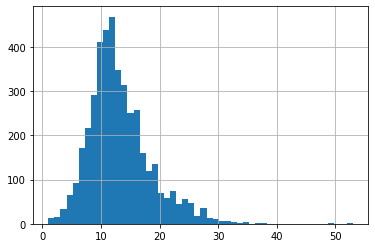

In [0]:
df.Sxx.apply(lambda x: x.shape[1]).hist(bins = 50)

Several outlying spectrograms have sequence lengths of approximately 50, whereas the majority are less than 40. We will remove spectrograms with length greater than 40 to reduce the padding required when training the model.

In [0]:
df = df[df.Sxx.apply(lambda x: x.shape[1] < 40)]

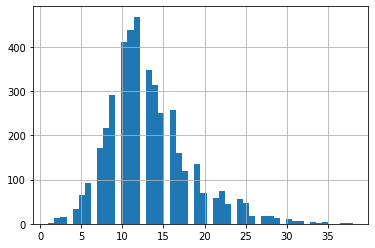

In [0]:
df.Sxx.apply(lambda x: x.shape[1]).hist(bins = 50)

The aplitudes of individual spectrograms are now normalized to the range 0-1 by dividing by the spectrogram's maximum amplitude

In [0]:
df.Sxx = df.Sxx.apply(lambda x: x / np.max(x))

In [0]:
df.Sxx = df.Sxx.apply(lambda x: x.T)
df = df.reset_index()

Convert tones to one-hot eoncoded vectors and add zero padding such that sequence lengths are all equal. The tones [1, 2, 3, 4, 5] are also mapped to [0, 1, 2, 3, 4] to avoid using an empty 0 class in the model.

In [0]:
df.tones = df.tones.apply(lambda x: to_categorical(x-1, num_classes=5))

Finally split the dataframe into training and validation sets

In [0]:
x_train, x_val, y_train, y_val = train_test_split(df.Sxx.values, df.tones.values, test_size=0.2, stratify=np.array(df.tones.to_list()))

train_df = pd.DataFrame({'Sxx': x_train, 'tones': y_train})
val_df = pd.DataFrame({'Sxx': x_val, 'tones': y_val})

## Model architechure

In this section we define and train the architecture for tone prediction. A recurrent neural network using LSTM cells is first used to encode the spectrograms to a single vector. This vector is then fed into a single dense output layer with 5 nodes for the 5 tones. 

In [0]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy

In [0]:
BATCH_SIZE = 32
EPOCHS = 20
SPECTROGRAM_INP_SIZE = 86 # frequency dimension
STEPS_PER_EPOCH = 80 #train_df.shape[0]//BATCH_SIZE

In [0]:
def training_batch_generator(epochs, batch_size):
    """
    Generates batchs of training data from the training dataframe
    input data: a list of numpy arrays shape (None, 86)
    Yields a list of [encoder input data (spectrograms), target data (one-hot encoded tones)]
    """
    for epoch in range(epochs):
    epoch_data = train_df.sample(2560).reset_index()
    for i in range(80):
        batch = epoch_data.loc[i*(batch_size-1):(i+1)*(batch_size-1), :]
        encoder_input = batch.Sxx.to_list()

        max_input_sequence_length = max([sequence.shape[0] for sequence in encoder_input])
        encoder_input = [np.pad(sequence, ((0, max_input_sequence_length - sequence.shape[0]), (0, 0))) for sequence in encoder_input]

        yield np.array(encoder_input), np.array(batch.tones.to_list())

Define a custom callback that prints the validation loss and accuracy after each epoch and adds these data to the model training history.

In [0]:
class ValidationCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):

    encoder_input = val_df.Sxx.to_list()
    max_input_sequence_length = max([sequence.shape[0] for sequence in encoder_input])
    encoder_input = [np.pad(sequence, ((0, max_input_sequence_length - sequence.shape[0]), (0, 0))) for sequence in encoder_input]

    target = np.array(val_df.tones.to_list())
    pred = self.model.predict(np.array(encoder_input))

    cce = CategoricalCrossentropy()
    loss = cce(tf.convert_to_tensor(target), tf.convert_to_tensor(pred)).numpy()
    #loss = tf.reduce_mean(tf.categorical_crossentropy(tf.convert_to_tensor(target), tf.convert_to_tensor(pred))).numpy()

    acc = Accuracy()
    acc.update_state(np.argmax(target, axis=1), np.argmax(pred, axis=1))

    print(" validation loss: {0:.4f}, validation acc: {1:.4f}".format(loss, acc.result().numpy()))

    if 'val_loss' in self.model.history.history.keys():
        self.model.history.history["val_loss"].append(loss)
    else:
        self.model.history.history["val_loss"]= [loss]

    if 'val_acc' in self.model.history.history.keys():
        self.model.history.history["val_acc"].append(acc.result().numpy())
    else:
        self.model.history.history["val_acc"]= [acc.result().numpy()]

Because the size labeled dataset is limited, we use a pretrained LSTM encoder for the first section of the architecture. This encoder was pretrained as an autoencoder using a larger dataset of similar Chinese pronunciation audio data for which labels were not available. See LSTM Autoencoder for RNN Tone Prediction for details.

In [0]:
pretrained_model = load_model("/content/drive/My Drive/tone_recognition_autoencoder/latest_autoencoder_weights.hdf5")

In [0]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, SPECTROGRAM_INP_SIZE))

# The pretrained model encoder layer
encoder = pretrained_model.layers[1]

# Discard the encoder states and save the encoder output
encoder_outputs, _, _ = encoder(encoder_inputs)

dropout_layer = Dropout(0.5)
dropout_output = dropout_layer(encoder_outputs)

# Dense softmax layer with 5 nodes for the 5 tones
output_layer = Dense(5, activation='softmax')
outputs = output_layer(dropout_output)

model = Model(encoder_inputs, outputs)

#The adam optimizer is modified to reduce the learning rate by a factor of 10
#adam = Adam(learning_rate=0.0001)
rmsprop = RMSprop(learning_rate=0.0001, rho=0.9)

model.compile(optimizer=rmsprop, loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 86)]        0         
_________________________________________________________________
lstm_8 (LSTM)                [(None, 256), (None, 256) 351232    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 352,517
Trainable params: 352,517
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit_generator(training_batch_generator(epochs=EPOCHS, batch_size=BATCH_SIZE),
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              callbacks=[ValidationCallback()],
                              )

Epoch 1/20
80/80 [==============================] - 10s 129ms/step - loss: 1.4999 - accuracy: 0.3637
Epoch 2/20
80/80 [==============================] - 9s 109ms/step - loss: 1.2999 - accuracy: 0.5125
Epoch 3/20
80/80 [==============================] - 9s 113ms/step - loss: 1.1039 - accuracy: 0.6152
Epoch 4/20
80/80 [==============================] - 9s 116ms/step - loss: 0.9402 - accuracy: 0.6793
Epoch 5/20
80/80 [==============================] - 9s 119ms/step - loss: 0.8436 - accuracy: 0.7164
Epoch 6/20
80/80 [==============================] - 9s 113ms/step - loss: 0.7732 - accuracy: 0.7410
Epoch 7/20
80/80 [==============================] - 9s 115ms/step - loss: 0.7301 - accuracy: 0.7648
Epoch 8/20
80/80 [==============================] - 9s 114ms/step - loss: 0.6810 - accuracy: 0.7852
Epoch 9/20
80/80 [==============================] - 10s 121ms/step - loss: 0.6511 - accuracy: 0.7922
Epoch 10/20
80/80 [==============================] - 9s 112ms/step - loss: 0.6191 - accuracy: 0.80

View a chart of the model training history

[]

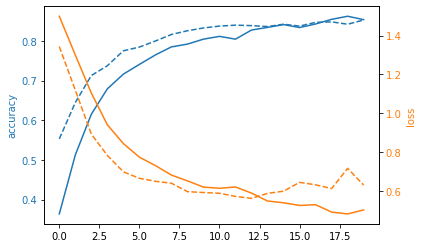

In [0]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['accuracy'], color='C0')
ax1.plot(history.history['val_acc'], color='C0', linestyle='--')
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], color='C1')
ax2.plot(history.history['val_loss'], color='C1', linestyle='--')
ax1.set_ylabel('accuracy', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax2.set_ylabel('loss', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
plt.plot()

View some examples of spectrograms and the predicted tones

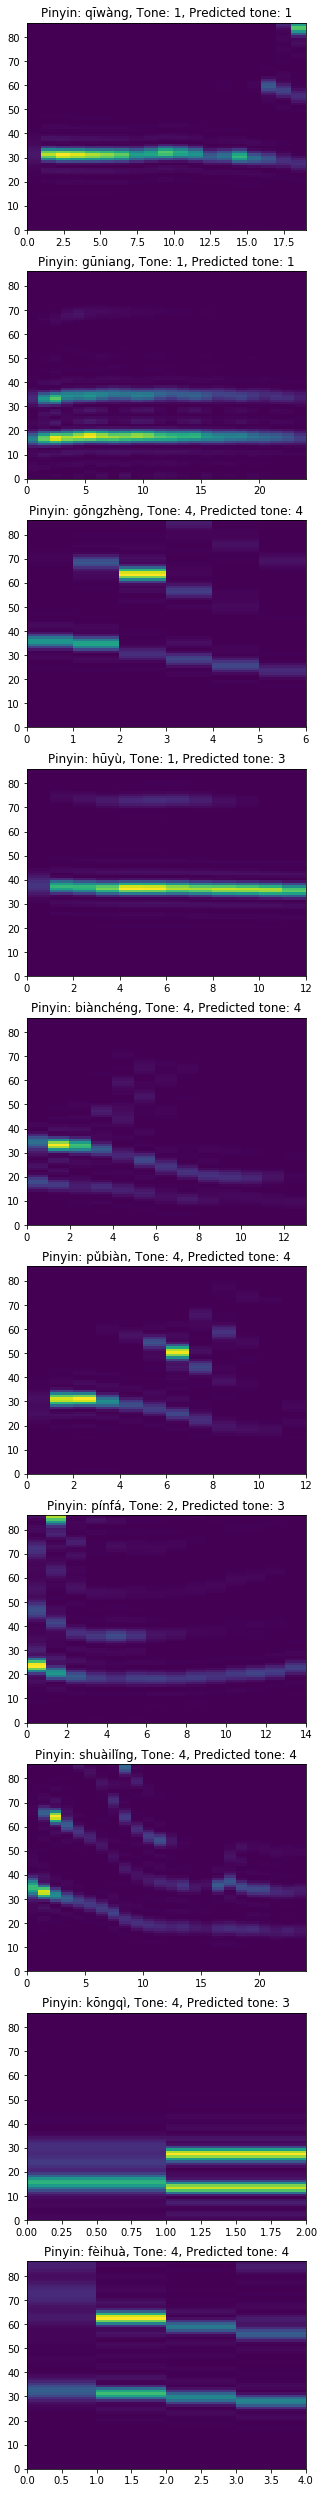

In [0]:
fig, ax = plt.subplots(10, 1, figsize=(5, 45))
for i, index in enumerate(random.sample(range(df.shape[0]), 10)):
    example = df.loc[index]
    ax[i].pcolormesh(example.Sxx.T)
    ax[i].set_title("Pinyin: {}, Tone: {}, Predicted tone: {}".format(example.pinyin,
                                                                np.argmax(example.tones)+1,
                                                                np.argmax(model.predict(np.expand_dims(example.Sxx, 0)))+1))
plt.show()

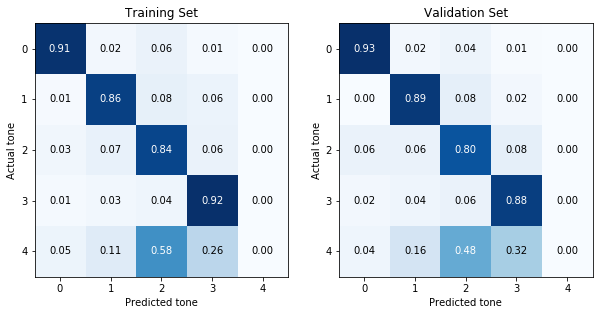

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, (encoder_input, target) in enumerate([(train_df.Sxx.to_list(), np.array(train_df.tones.to_list())), 
                      (val_df.Sxx.to_list(), np.array(val_df.tones.to_list()))]):

    max_input_sequence_length = max([sequence.shape[0] for sequence in encoder_input])
    encoder_input = [np.pad(sequence, ((0, max_input_sequence_length - sequence.shape[0]), (0, 0))) for sequence in encoder_input]

    pred = model.predict(np.array(encoder_input))

    cm = tf.math.confusion_matrix(np.argmax(target, axis=1), 
                                      np.argmax(pred, axis=1)).numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax[i].imshow(cm, cmap=plt.cm.Blues)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for m in range(cm.shape[0]):
        for n in range(cm.shape[1]):
            ax[i].text(n, m, format(cm[m, n], fmt),
                      ha="center", va="center",
                      color="white" if cm[m, n] > thresh else "black")

    ax[i].set_xlabel("Predicted tone")
    ax[i].set_ylabel("Actual tone")

ax[0].set_title("Training Set")
ax[1].set_title("Validation Set")
plt.show()

For both training and validation sets, tone 5 is misclassified for all instances. 

In [0]:
model.save('/content/drive/My Drive/seq_tone_model.h5')

## Evaluation

We can test the trained model using audio input in the browser

In [0]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    audio = AudioSegment.from_file(BytesIO(b))
    return audio

In [0]:
def predict_tone(num_syl):
    print("Recording: start")
    audio = record(sec=3)
    print("Recording: stop")
    audio.export(r'/content/drive/My Drive/word.wav', format="wav")
    fs, data = wavfile.read(r'/content/drive/My Drive/word.wav')
    if len(data.shape) > 1:
      data = data.T[0]
    plt.plot(data)
    plt.show()
  
    if num_syl == 1:
        f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024, nfft=1024*4)
        Sxx = Sxx[:86]
        Sxx = Sxx / np.max(Sxx)
        Sxx = trim_silences(Sxx)
        plt.pcolormesh(Sxx)
        plt.show()
        return [model.predict(np.expand_dims(Sxx.T, 0))]
    elif num_syl == 2:
        fig, ax = plt.subplots(1, 2)
        f, t, Sxx = signal.spectrogram(data, fs, nperseg=1024, nfft=1024*4)
        Sxx = Sxx[:86]
        Sxx = trim_silences(Sxx)
        #Separate the sylables
        Sxx1, Sxx2 = split_spectrogram(Sxx)
        Sxx1 = Sxx1 / np.max(Sxx1)
        Sxx2 = Sxx2 / np.max(Sxx2)
        ax[0].pcolormesh(Sxx1)
        ax[1].pcolormesh(Sxx2)
        plt.show()
        return [model.predict(np.expand_dims(Sxx1.T, 0)), model.predict(np.expand_dims(Sxx2.T, 0))]

Run the following cell to record a Chinese word. The model predicts the tones of its component sylables.

Please choose the number of sylables (1 or 2): 2
Recording: start


<IPython.core.display.Javascript object>

Recording: stop


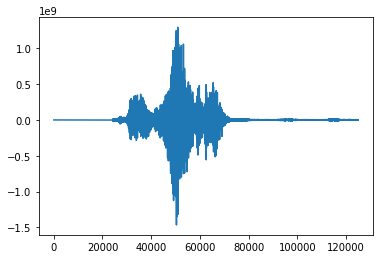

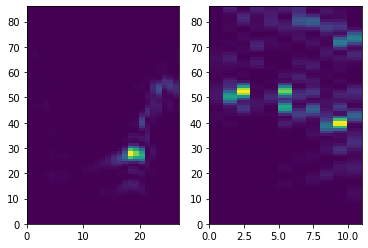

[array([[0.15440603, 0.4760544 , 0.19953135, 0.12345186, 0.04655645]],
      dtype=float32), array([[0.17771745, 0.23659146, 0.26627418, 0.17338577, 0.14603114]],
      dtype=float32)]
Sylable 1 prediction: 2
Tone 1 probability: 15.440603%
Tone 2 probability: 47.605440%
Tone 3 probability: 19.953135%
Tone 4 probability: 12.345186%
Tone 5 probability: 4.655645%
...
Sylable 2 prediction: 3
Tone 1 probability: 17.771745%
Tone 2 probability: 23.659146%
Tone 3 probability: 26.627418%
Tone 4 probability: 17.338577%
Tone 5 probability: 14.603114%
...


In [0]:
num_syl = int(input("Please choose the number of sylables (1 or 2): "))
prediction = predict_tone(num_syl=num_syl)
print(prediction)
for i, sylable in enumerate(prediction):
    print("Sylable {:d} prediction: {:d}".format(i + 1, np.argmax(sylable) + 1))
    for j in range(5):
        print("Tone {:d} probability: {:f}%".format(j + 1, sylable[0][j]*100))
    print("...")